<a href="https://colab.research.google.com/github/RuslanTs/Two_sigma_rental_prediction/blob/master/two_sigma_rental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sources

В секции с визуализацией использовал:
https://www.kaggle.com/viveksrinivasan/visualizing-two-sigma-connect-dataset


В итоге не принесло результатов или даже уменьшило скор:
* Попытки изменить нулевые building_id 
* Обработка вылетов в цене и числе ванных комнат (приравнять вылет к результату 99 перцентиля) 
* попытка стандартизировать display_address 
* добавление фичи принадлежность к топ 100 менеджерам
* изменение нулевых координат средними
* попытки включить description с tfidf как фичи

Результат принесли:

*  фича, на основе building_id - принадлежность к топ 10 зданий
* удаление фичи building_id
* фичи на основе цены, кол-ва спален и ванных комнат и их комбинации
* добавление PCA сжатого до одной размерности
* фичи на основе даты/времени
* фича на основе listing_id (data_leak)
* добавление фич, основанных на координатах (расстояние до центрально парка, статуи свободы, расстояние до средних координат)
* фичи, основанные на длине description и features, число фотографий
* предобработка display_address перед категоризацией

#working with kaggle api, reading, unzipping

In [0]:
!pip3 install kaggle


In [0]:
import os
user = #enter a username
key = #enter a key
 
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c two-sigma-connect-rental-listing-inquiries

 85% 17.0M/20.0M [00:00<00:00, 17.2MB/s]
100% 20.0M/20.0M [00:00<00:00, 34.0MB/s]
 30% 9.00M/30.0M [00:01<00:02, 7.75MB/s]
100% 30.0M/30.0M [00:01<00:00, 19.5MB/s]
  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 86.4MB/s]
 60% 33.0M/55.3M [00:00<00:00, 25.5MB/s]
100% 55.3M/55.3M [00:00<00:00, 63.3MB/s]
 82% 5.00M/6.13M [00:00<00:00, 8.22MB/s]
100% 6.13M/6.13M [00:00<00:00, 9.67MB/s]


In [0]:
!unzip test.json.zip
!unzip train.json.zip
!unzip images_sample.zip

Archive:  test.json.zip
  inflating: test.json               
Archive:  train.json.zip
  inflating: train.json              
Archive:  images_sample.zip
   creating: images_sample/
  inflating: images_sample/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/images_sample/
  inflating: __MACOSX/images_sample/._.DS_Store  
   creating: images_sample/6811957/
  inflating: images_sample/6811957/6811957_33d08c8dc440c89bccc8d9889c5485a6.jpg  
  inflating: images_sample/6811957/6811957_3dad56e8bf3477b2900ca39d57df041e.jpg  
  inflating: images_sample/6811957/6811957_7d3ab8175d23fee64c0651b1bc16f2cc.jpg  
  inflating: images_sample/6811957/6811957_83a4e2e75ea15a5a1d2cc9de3407b1b9.jpg  
  inflating: images_sample/6811957/6811957_acbdbbe6ff435b9d4f520db6da1ada9a.jpg  
   creating: images_sample/6811958/
  inflating: images_sample/6811958/6811958_1fe0076c8b481e0af2223afab02503da.jpg  
  inflating: images_sample/6811958/6811958_23ceae42d2c88ffc5a057db1deb346c1.jpg  
  inflating: images_samp

In [0]:
import pandas as pd
import numpy as np

In [0]:
data_path = ""
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 15)
(74659, 14)


#A first look at the data

In [0]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


In [0]:
test_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


In [0]:
train_df.shape,test_df.shape

((49352, 15), (74659, 14))

In [0]:
train_df.interest_level.describe()

count     49352
unique        3
top         low
freq      34284
Name: interest_level, dtype: object

In [0]:
train_df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
interest_level     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [0]:
len(train_df.manager_id.unique()), len(test_df.manager_id.unique())

(3481, 3851)

In [0]:
#data types checking
train_df.get_dtype_counts()

float64    3
int64      3
object     9
dtype: int64

#Lets see some distributions and visualizations

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

###Wordcloud for text data

In [0]:
#Preprocessing
from wordcloud import WordCloud
text = ''
text_dispadd = ''
text_street = ''
text_desc =''
for ind, row in train_df.iterrows():
    for feature in row['features']:
        text = " ".join([text, "_".join(feature.strip().split(" "))])
    text_dispadd = " ".join([text_dispadd,"_".join(row['display_address'].strip().split(" "))])
    text_street = " ".join([text_street, row['street_address']])
    text_desc=" ".join([text_desc, row['description']])
text = text.strip()
text_dispadd = text_dispadd.strip()
text_street = text_street.strip()
text_desc = text_desc.strip()

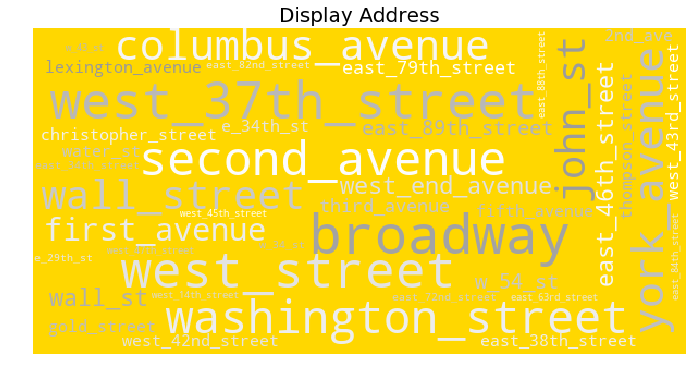

In [0]:
#address

import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


# wordcloud for display address
plt.figure(figsize=(12,6))
wc = WordCloud(background_color='gold', width=600, height=300,
                      max_font_size=50, max_words=40).generate(text_dispadd)
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
#plt.imshow(wc)
plt.title("Display Address", fontsize=20)
plt.axis("off")
plt.show();

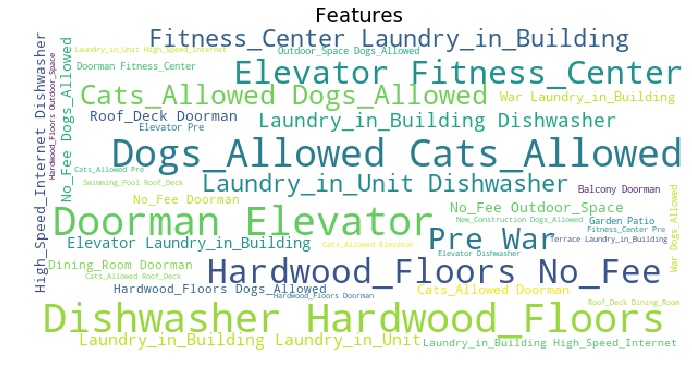

In [0]:
#Features

plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300,
                      max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Features", fontsize=20)
plt.axis("off")
plt.show()

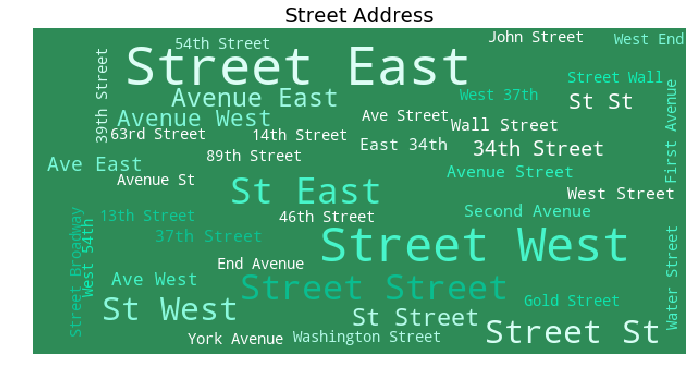

In [0]:
#Street address

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(165, 90%%, %d%%)" % random.randint(39, 145)


# wordcloud for street address
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='seagreen', width=600, height=300,
                      max_font_size=50, max_words=40).generate(text_street)
wordcloud.recolor(color_func=green_color_func, random_state=8)
plt.imshow(wordcloud)
plt.title("Street Address", fontsize=20)
plt.axis("off")
plt.show()

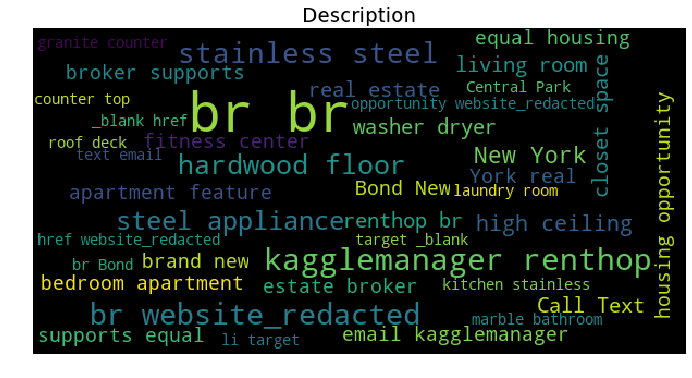

In [0]:
#Description

plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='black', width=600, height=300,
                      max_font_size=50, max_words=40).generate(text_desc)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Description", fontsize=20)
plt.axis("off")
plt.show()

###Interest_level

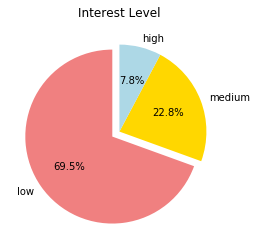

In [0]:
#Interest Level

labels = ["low","medium","high"]
sizes = train_df.interest_level.value_counts().values
explode=[0.1,0,0]
colors = [  'lightcoral','gold','lightblue']
patches, texts,autotexts= plt.pie(sizes, labels=labels,colors=colors,explode=explode,autopct="%1.1f%%",
                        startangle=90)
plt.title("Interest Level")
plt.show()

###price

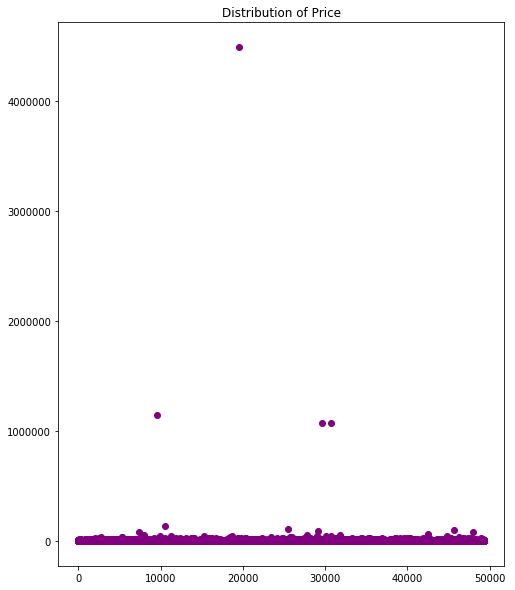

In [0]:
plt.figure(figsize=(8, 10))
plt.scatter(range(train_df.shape[0]), train_df["price"].values,color='purple')
plt.title("Distribution of Price");

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Distribution of Price')

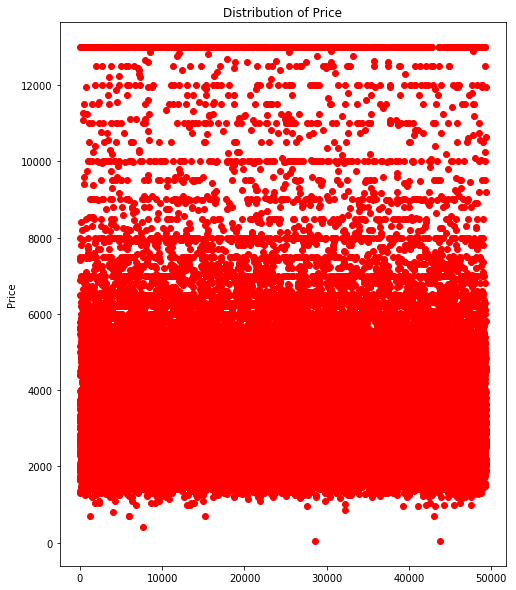

In [0]:
#заменим выбросы в цене на цену, попадающую в 99 перцентиль - ухудшило результат
# ulimit = np.percentile(train_df.price.values, 99)
# train_df['price'].ix[train_df['price']>ulimit] = ulimit

plt.figure(figsize=(8,10))
plt.scatter(range(train_df.shape[0]), train_df['price'].values,color='red')
plt.ylabel('Price')
plt.title("Distribution of Price")


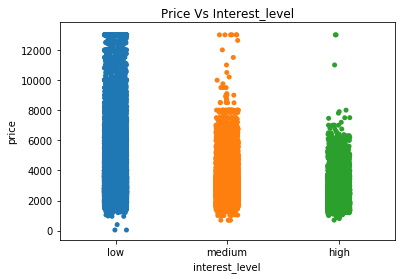

In [0]:
order = ['low', 'medium', 'high']
sns.stripplot(train["interest_level"],train["price"],jitter=True,order=order)
plt.title("Price Vs Interest_level");

###Bedrooms

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0.5, 0, 'Number of Bedrooms')

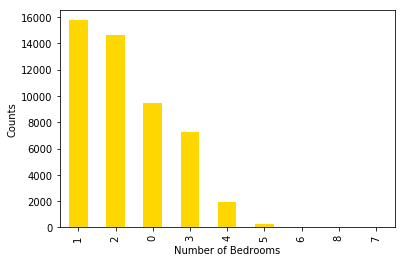

In [0]:
train['bedrooms'].value_counts().plot(kind='bar', colors='gold')
plt.ylabel('Counts')
plt.xlabel('Number of Bedrooms')

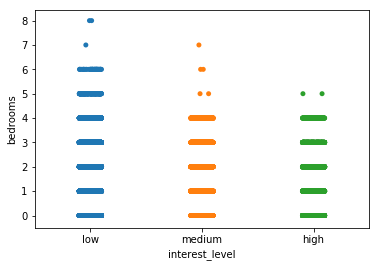

In [0]:
sns.stripplot(y="bedrooms", x="interest_level",data=train,jitter=True,order=order);

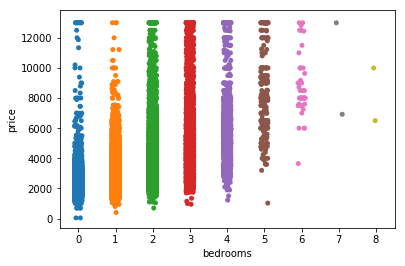

In [0]:
sns.stripplot(x='bedrooms', y='price', data=train, jitter=True)

###Bathrooms

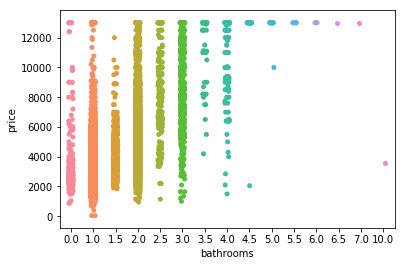

In [0]:
sns.stripplot(x='bathrooms', y='price', data=train, jitter=True)

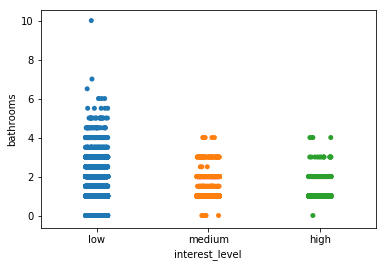

In [0]:
sns.stripplot(y='bathrooms', x='interest_level', data=train, jitter=True, order=order)

Один дом с 10 ванными комнатами - очень похоже на выброс,  изменим это значение
P.s. не стоит, также ухудшило результат

In [0]:
# ulimit = np.percentile(train_df.bathrooms.values, 99)
# train_df['bathrooms'].ix[train_df['bathrooms']>ulimit] = ulimit

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


###Listing Id

Text(0.5, 1.0, 'Listing_Id Vs Interest_level')

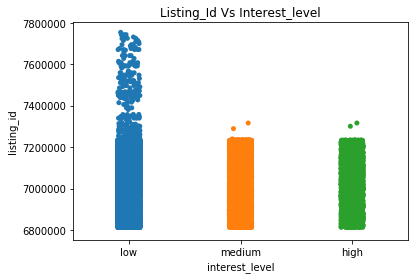

In [0]:
sns.stripplot(y="listing_id", x="interest_level",data=train,jitter=True,order=order)
plt.title("Listing_Id Vs Interest_level")

Из графика выше кажется, что listing id  может быть полезной фичей, т.к. очень высокие значения listing_id представляют недвижимость с низким спросом. К тому же в данном соревновании есть Data Leak, связанный с временем создания объявлений
https://www.kaggle.com/zeroblue/visualizing-listing-id-vs-interest-level
https://www.youtube.com/watch?v=HUVhb1J0mUw

##Dates

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


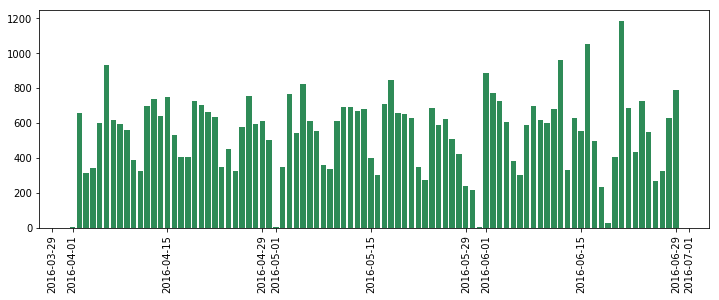

In [0]:
cnt_srs = train_df['date'].value_counts()

plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, color='seagreen')
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.show()

объявления были созданы в период с Апреля по Июль 2016

##Hour

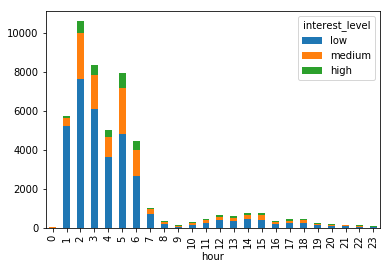

In [0]:
hourDF = train_df.groupby(['hour', 'interest_level'])['hour'].count().unstack('interest_level').fillna(0)
hourDF[['low','medium',"high"]].plot(kind='bar', stacked=True);

##Month

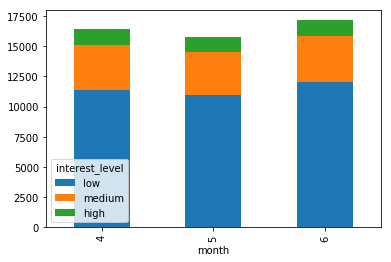

In [0]:
monthDF = train_df.groupby(['month', 'interest_level'])['month'].count().unstack('interest_level').fillna(0)
monthDF[['low', 'medium', 'high']].plot(kind='bar', stacked=True)

##Photos

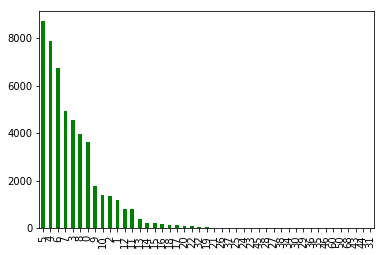

In [0]:
train_df.num_photos.value_counts().plot(kind='bar', color='green')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


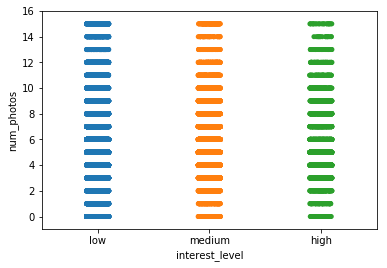

In [0]:
train_df['num_photos'].ix[train_df['num_photos']>15] = 15
sns.stripplot(y="num_photos", x="interest_level",data=train_df,jitter=True,order=order);

Данные равномерно распределены по всем уровням интереса

##Features

Text(0.5, 0, 'Number of features')

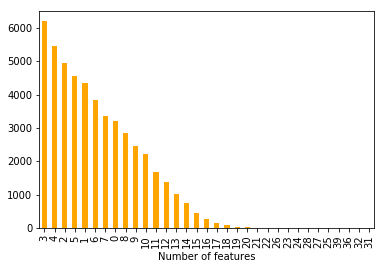

In [0]:
train_df.num_features.value_counts().plot(kind='bar', color='orange')
plt.xlabel('Number of features')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


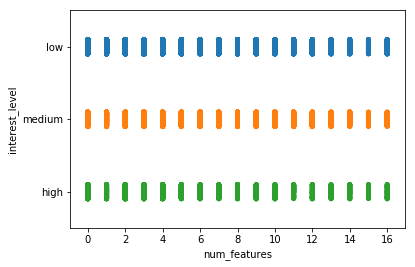

In [0]:
train_df.num_features.ix[train_df['num_features'] > 16] = 16
sns.stripplot(x='num_features', y='interest_level', data=train_df, jitter=True, order=order)

Данные равномерно распределены по всем уровням интереса

##High profile Managers

 to find top managers with more than 80 listings altogether with low,medium or high interest levels and more than 30 listings with high interest levels.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


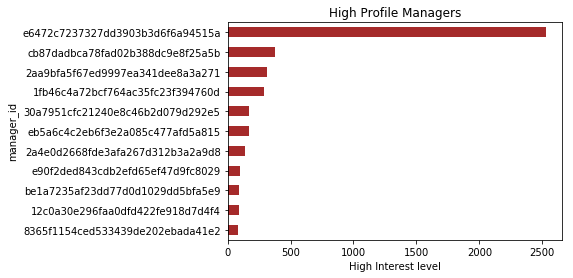

In [0]:
managerDF = train_df.groupby(['manager_id', 'interest_level'])['manager_id'].count().unstack('interest_level').fillna(0)
managerDF["sum"]=managerDF.sum(axis=1)
x=managerDF[ (managerDF['sum'] > 80) & (managerDF['high'] > 30)]
managerDF.head()
x.sort_values("sum",inplace=True)
plt.title("High Profile Managers")
plt.xlabel("High Interest level")
plt.ylabel("Manager ID")
x = x
x["sum"].plot(kind='barh',color="brown");

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


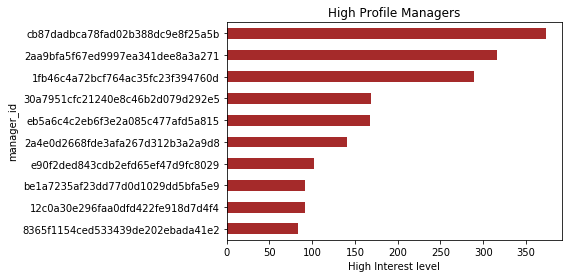

In [0]:
managerDF = train_df.groupby(['manager_id', 'interest_level'])['manager_id'].count().unstack('interest_level').fillna(0)
managerDF["sum"]=managerDF.sum(axis=1)
x=managerDF[ (managerDF['sum'] > 80) & (managerDF['high'] > 30)]
managerDF.head()
x.sort_values("sum",inplace=True)
plt.title("High Profile Managers")
plt.xlabel("High Interest level")
plt.ylabel("Manager ID")
x = x[x.index != 'e6472c7237327dd3903b3d6f6a94515a']
x["sum"].plot(kind='barh',color="brown");

##High profile buildings

to find top buildings with more than 60 listings altogether with low,medium or high interest levels and more than 15 listings with high interest levels.

In [0]:
import matplotlib.pyplot as plt

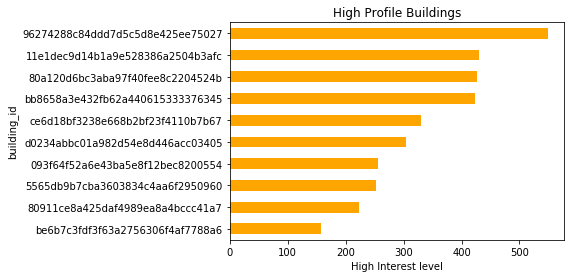

In [0]:
buildingDF = train_df.groupby(['building_id', 'interest_level'])['building_id'].count().unstack('interest_level').fillna(0)
buildingDF['sum']=buildingDF.sum(axis=1)
buildingDF['sum']=buildingDF.sum(axis=1)
x=buildingDF[(buildingDF['sum'] >60) & (buildingDF['high'] >15)]
buildingDF.head()

#removing outliers

x=x[x.index != '0']
x.sort_values('sum', inplace=True)
plt.title("High Profile Buildings")
plt.xlabel("High Interest level")
plt.ylabel("Building ID")
x["sum"].plot(kind='barh',color="orange");

#Feature engineering

In [0]:
train_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06



* В данных нет пропущенных значений, но, возможно, имеются выбросы в колонке с ценами, т.к. максимальная цена отличается на несколько порядков от 50 и 75 перцентилей + большое стандартное отклонение.
* Также, похоже, что есть опечатки/неточности в колонках bathrooms, bedrooms минимальные значения для этих колонок равны 0.
* longitude и latitude, некоторые строки имеют нулевые значения в этих колонках
* есть дома с building_id = 0
 

##work with wrong latitude and longitude - не дало прирост в результаты

In [0]:
#try to handle with it

train_df[(train_df['latitude'] == 0) & (train_df['longitude'] !=0)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level


In [0]:
train_df[(train_df['latitude'] != 0) & (train_df['longitude'] ==0)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level


In [0]:

train_df[(train_df['latitude'] == 0) & (train_df['longitude'] ==0)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
106350,5.0,6,0,2016-04-18 02:14:51,***NO BROKER FEE***<BR><BR>Situated on a gorge...,Decatur Street,"[Garden/Patio, Terrace, No Fee, Outdoor Space,...",0.0,6888639,0.0,c639a76f31c41923cd91d23875a72264,[https://photos.renthop.com/2/6888639_87eb648f...,9995,259 Decatur Street,low
2028,1.0,1,1490317c3a31185f0c8115f01d1acc5b,2016-05-31 22:26:06,Gorgeous one bedroom in Sunset Park-Private en...,"Sunset Park, Brooklyn","[hardwood floors, own entrance, oak cabinets]",0.0,7087715,0.0,2290f91e45472ecaf0983c5af18098ce,[https://photos.renthop.com/2/7087715_mb_3517f...,1750,145 28 Street,low
37426,1.0,1,0,2016-06-01 19:59:46,Big 2 bedroom in clean and quite multi family ...,88 van Sicklen street,"[Reduced Fee, Cats Allowed]",0.0,7094527,0.0,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7094527_mb_7f196...,1725,Van Sicklen street,low
39134,1.0,2,a1b2bd0758c6f14be815e4d9382b8169,2016-06-16 15:38:11,Flatiron Duplex!At the intersection of Flatiro...,"Flatiron, Kips Bay, Gramercy","[Views, No Fee, Duplex, Laundry in Unit, Cats ...",0.0,7174094,0.0,42cb18c3898c42b7512065e7d3e1e8bd,[https://photos.renthop.com/2/7174094_mb_e3c7e...,4395,219 E 28th,low
46941,1.0,2,8f837ada8d7ec5d251a369cd5909af7c,2016-05-07 08:15:32,Spacious and bright 2 bedroom fully renovated ...,Madison Ave,"[Laundry in Unit, Roof Deck, <null>]",0.0,6981091,0.0,b93b333035403fc090fb51372fb082f9,[https://photos.renthop.com/2/6981091_mb_efd73...,2950,1632 Madison Ave,medium
49884,1.0,2,ebb1fe8e32b8565f057a20abc495a2b5,2016-05-10 10:25:19,"New construction, luxury highrise, The two bed...",24th St LIC,"[Doorman, Fitness Center, Laundry in Unit, Cat...",0.0,6991620,0.0,dd85ae9242e4012be8a386d37c1d9453,[https://photos.renthop.com/2/6991620_mb_e7c05...,3619,41-42 24th St,low
63688,4.0,3,f389c8eb16e5d0c771615fb30f3cc9d6,2016-05-11 18:07:15,"This high floor, mint condition, corner unit b...",450 East 83rd Street apt 21D (Furnished),"[Furnished, Laundry In Unit, Cats Allowed, Dog...",0.0,6997950,0.0,355ccd9223a7481c5d223d39b4e65e90,[https://photos.renthop.com/2/6997950_4ef02f8c...,16500,450 East 83rd Street,low
66197,1.0,1,4d7c804afea366c666731bee9c56919e,2016-05-10 14:30:12,NO FEE! Spacious one bedroom apartment in a F...,west 87,"[Doorman, Fitness Center, No Fee, Cats Allowed...",0.0,6991901,0.0,7d4f285c15b11c61bacfbf8e7a49252d,[https://photos.renthop.com/2/6991901_mb_e3232...,3600,247 west 87,low
69423,1.0,2,55ab81a4ccd5ea862fba344dc29f1463,2016-05-24 17:43:39,Fantastic 2 bed with the works! It has 2 queen...,118 W 109th,"[Cats Allowed, Dogs Allowed, No Fee, Laundry i...",0.0,7062134,0.0,91c09ae8bfdc7e5ba7d6385e33a6064d,[https://photos.renthop.com/2/7062134_mb_9f18c...,3200,118 W 109th,low
70841,1.0,1,09e6efa1a58a3cd753aeee80bdf5ec36,2016-05-10 10:11:20,No fee! Prime NOLITA neighborhood with amazing...,Mott St,"[No Fee, <null>]",0.0,6991613,0.0,dd85ae9242e4012be8a386d37c1d9453,[https://photos.renthop.com/2/6991613_mb_b7cec...,3495,246 Mott St,low


In [0]:
test_df[(test_df['latitude'] == 0) & (test_df['longitude'] ==0)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
100928,1.0,1,f691462d947b2e7b76d3762cd820b3f9,2016-04-05 00:33:01,Beautiful -- 1 Bedroom -- apartment for a deal...,East 4th and Second Ave.,"[Cats Allowed, Dogs Allowed]",0.0,6822541,0.0,7aef2fa5785ea1c53a91a81d84000621,[https://photos.renthop.com/2/6822541_mb_21498...,2400,118 East 4th Street
101935,1.0,0,65fe76a07e88d59c78a1d9ca89ccf55c,2016-04-06 12:21:52,Great studio in midtown luxury doorman buildin...,Midtown West,"[Doorman, Elevator, Fitness Center, Laundry in...",0.0,6834416,0.0,2d944ec1e03ebdcb260564ae6d54ea73,[https://photos.renthop.com/2/6834416_mb_45264...,2500,360 W. 43rd Street
104983,1.0,1,cd17978b43ed27e928fc387b36ec9bde,2016-04-06 16:41:48,Beautiful apartment in a tree lined block. The...,CROWN HEIGHTS,[HURRY & TAKE THIS UNIT OF THE MARKET! REDUCED...,0.0,6834708,0.0,b4bba81d7199f8b70e4f0e9c7beea29c,[https://photos.renthop.com/2/6834708_mb_1914c...,2075,647 Prospect Place
108702,1.0,2,b0b8466ebad35adf59067427c4c92301,2016-04-05 12:51:47,Get your June 1st apartment now b4 the rush! I...,52nd/9th ave / 785 9th ave,"[Common Outdoor Space, amazing city views from...",0.0,6827054,0.0,18cc79d7d9892af62a70c085d0182782,[https://photos.renthop.com/2/6827054_mb_7c7f7...,3100,785 9th ave
11348,1.0,3,f1833846e5f958df2a97e2b0258820e0,2016-06-01 10:29:29,*Mgmt is accepting move ins from June 1- July ...,965 Amsterdam,"[Laundry in Unit, Dogs Allowed, No Fee, Cats A...",0.0,7239720,0.0,91c09ae8bfdc7e5ba7d6385e33a6064d,[https://photos.renthop.com/2/7093990_mb_29fa8...,4000,965 Amsterdam
117661,1.0,1,d96a366c9877e16d3a4286b8c2698b1d,2016-04-15 16:25:04,"*****AMAZING DEAL, this unit WON'T LAST**** EN...",Bedford Park,"[Elevator, Laundry In Building, Laundry in Bui...",0.0,6880263,0.0,b27a8b1544b9efd0dd0476dbf197cf3a,[https://photos.renthop.com/2/6880263_dbd445f1...,1250,2964 Perry Avenue
23825,1.0,3,f1833846e5f958df2a97e2b0258820e0,2016-06-01 10:29:29,*Mgmt is accepting move ins from June 1- July ...,965 Amsterdam,"[Laundry in Unit, Dogs Allowed, No Fee, Cats A...",0.0,7093990,0.0,91c09ae8bfdc7e5ba7d6385e33a6064d,[https://photos.renthop.com/2/7093990_mb_29fa8...,4000,965 Amsterdam
28197,1.0,1,a37f48a180071ce25f580ca5712d8101,2016-06-26 21:22:21,WoW 1 Bedroom I East Village under market valu...,e 5th and 1st ave,[],0.0,7219565,0.0,28d0fc0861cb780882b642cfb66e9507,[],2075,e 5 th
32592,1.0,2,bf7acc01e1a2e227162c9b5a20b3c5ea,2016-06-06 13:16:48,Flex two bed!! Pics of actual unit!! Text or ...,330 west 45th,"[Doorman, Elevator, Laundry in Building]",0.0,7116669,0.0,c7becdd5c4a5f8a28bdc91cfefe794c7,[https://photos.renthop.com/2/7116669_mb_8efb5...,3400,330 west 45th
34487,1.0,1,d82a0ad657331e9de8ee5baa4f80ad81,2016-06-02 05:08:35,"Gorgeous, spacious 1 BR/flex 2 on the Upper We...",W. 156,[],0.0,7098402,0.0,b93b333035403fc090fb51372fb082f9,[https://photos.renthop.com/2/7098402_mb_20630...,1925,515 W. 156


In [0]:
train_df['longitude'][(train_df['latitude'] == 0) & (train_df['longitude'] ==0)].index

Int64Index([106350,   2028,  37426,  39134,  46941,  49884,  63688,  66197,
             69423,  70841,  76934,  85521],
           dtype='int64')

In [0]:
test_df[(test_df['latitude'] == 0) | (test_df['longitude'] ==0)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address


##working with builing id = 0 - не дало результатов, модель стала лучше, когда выкинул данную фичу

try to correct zeros in the building_ids with building_ids from the same coordinates

In [0]:
train_df['string'] = train_df['longitude'].astype(str) + train_df['latitude'].astype(str)

In [0]:
test_df['string'] = test_df['longitude'].astype(str) + test_df['latitude'].astype(str)

In [0]:
train_df['string'][train_df['building_id']==0].shape

(8286,)

In [0]:
# def new_build_id(df):
#   a = np.array(df[['building_id', 'string']][df['building_id'] == '0'])

#   b = np.array(df[['building_id', 'string']][df['building_id'] != '0'])
#   for i in range(len(a)):
#     for j in range(len(b)):
#       if a[i][1] == b[j][1]:
#          a[i] = b[j]
#   return a

In [0]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,listing_id_transformed,longitude_to_cp,latitude_to_cp,related_price,int_bath,longitude_to_median,latitude_to_median,longitude_to_statue_of_liberty,latitude_to_statue_of_liberty,log_price,expected_price,log_expected_price,top_building_id,bath_min_bedr,bath_plus_bedr,bath_times_bedr,price_dev_bath_and_bed,num_photos,num_features,num_description_words,created_year,created_month,created_day,created_hour,display_address_2,string,building_id_new
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,40.7145,7211212,-73.9425,1568,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,23484,medium,0,0.025785,0.070591,0.783254,0,0.0354,0.0373,0.102002,0.025253,8.006368,336.0,5.817111,0,1.5,4.5,4.5,545.454545,5,0,95,2016,6,24,7,11398,-73.942540.7145,53a5b119ba8f7b61d4e010512e0dfc85
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,Doorman Elevator Fitness_Center Cats_Allowed D...,40.7947,7150865,-73.9667,1988,[https://photos.renthop.com/2/7150865_be3306c5...,5465,23680,low,0,0.001585,0.009609,1.426828,1,0.0112,0.0429,0.077802,0.105453,8.606119,1087.5,6.991637,0,1.0,3.0,2.0,1366.250000,11,5,9,2016,6,12,12,8603,-73.966740.7947,c5c8a357cba207596b04d1afd1e4f130
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,Laundry_In_Building Dishwasher Hardwood_Floors...,40.7388,6887163,-74.0018,3733,[https://photos.renthop.com/2/6887163_de85c427...,2850,9827,high,0,0.033515,0.046291,0.744092,1,0.0239,0.0130,0.042702,0.049553,7.955074,616.0,6.423247,0,0.0,2.0,1.0,950.000000,8,4,94,2016,4,17,3,12784,-74.001840.7388,c3ba40552e2120b0acfc3cb5730bb2aa
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,Hardwood_Floors No_Fee,40.7539,6888711,-73.9677,282,[https://photos.renthop.com/2/6888711_6e660cee...,3275,14237,low,0,0.000585,0.031191,0.855053,1,0.0102,0.0021,0.076802,0.064653,8.094073,396.0,5.981414,0,0.0,2.0,1.0,1091.666667,3,2,80,2016,4,18,2,10054,-73.967740.7539,28d9ad350afeaab8027513a3e52ac8d5
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,Pre-War,40.8241,6934781,-73.9493,2618,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,19227,low,0,0.018985,0.039009,0.874634,1,0.0286,0.0723,0.095202,0.134853,8.116716,298.3,5.698100,1,3.0,5.0,4.0,558.333333,3,1,68,2016,4,28,1,13912,-73.949340.8241,0


In [0]:
def new_building_id(df):  
  a = np.array(df[['building_id', 'string']][df['building_id'] == '0'])

  b = np.array(df[['building_id', 'string']][df['building_id'] != '0'])  
  dictionary_with_building_id = {i:j for j,i in b}
  for i in range(len(a)):
    for j in dictionary_with_building_id:
      if a[i][1] == j:
        a[i][0] = dictionary_with_building_id[j]
  return a

In [0]:
train_values = new_building_id(train_df)
test_values = new_building_id(test_df)


In [0]:
train_df['building_id'][train_df['building_id'] == '0'].shape

(8286,)

In [0]:
train_df['building_id_2'] = [i for i in pd.DataFrame(train_values)[0]]
train_df['building_id_2'] = [i for i in pd.DataFrame(train_values)[0]]

Т.е. удалось исправить часть неправильно пронумерованных building_id, остальные, вероятно, являются зданиями с уникальными координатами (p.s Да, функция работает довольно медленно, я знаю)

##display_address
можно попробовать привести все отображаемые адреса к одинаковым, пользуясь координатами

P.s. также дало ухудшение метрики

In [0]:
train_df['display_address'] = [i.lower() for i in train_df['display_address']]

In [0]:
train_df['display_address'].value_counts()

broadway                                          438
east 34th street                                  355
second avenue                                     349
wall street                                       332
west 37th street                                  287
west street                                       259
first avenue                                      244
gold street                                       241
washington street                                 237
york avenue                                       228
john street                                       215
water street                                      214
east 39th street                                  200
east 89th street                                  195
west 54th street                                  193
fifth avenue                                      189
lexington avenue                                  189
west 42nd street                                  184
christopher street          

In [0]:
d={i:j for i,j in np.array(train_df[['string', 'display_address']])}

In [0]:
 def new_display_address(df):
  
  a = np.array(df[['display_address', 'string']])
  for i in range(len(a)):
    for j in d.keys():
      if a[i][1] == j:
         a[i][0] = d[j]
  return a

In [0]:
k = new_display_address(train_df)

In [0]:
k2 = new_display_address(test_df)

In [0]:
pd.DataFrame(k)[0].nunique()

5844

In [0]:
train_df['display_address_2'] = [i for i in pd.DataFrame(k)[0]]

In [0]:

test_df['display_address_2'] = [i for i in pd.DataFrame(k2)[0]]

##Bathrooms and bedrooms first look

In [0]:
#посмотрим на колонки bathrooms, bedrooms

train_df[(train_df['bathrooms'] == 0) & (train_df['bedrooms'] ==0)].shape

(157, 16)

In [0]:
train_df[(train_df['bathrooms'] == 0)].shape

(313, 16)

In [0]:
train_df[(train_df['bedrooms'] == 0)].shape

(9475, 16)

слишком много значений, где количество спален и/или количество ванных комнат = 0, думаю, это не опечатки, а действительные свойства данной недвижимости

##Feature generation

In [0]:
test_df['listing_id_transformed'] = (test_df['listing_id'] > 7400000).astype(dtype='int32')

In [0]:
train_df['listing_id_transformed'] = (train_df['listing_id'] > 7400000).astype(dtype='int32')

In [0]:
#т.к. данные дома находятся в нью-йорке можно добавить фичу расстояния до центрального парка

latitude_cp = 40.785091
longitude_cp =  -73.968285

train_df['longitude_to_cp'] = abs(train_df['longitude'] - longitude_cp)
train_df['latitude_to_cp'] = abs(train_df['latitude'] - latitude_cp)
test_df['longitude_to_cp'] = abs(test_df['longitude'] - longitude_cp)
test_df['latitude_to_cp'] = abs(test_df['latitude'] - latitude_cp)

In [0]:
mean_price = train_df.price.mean()

train_df['related_price'] = train_df['price']/mean_price
test_df['related_price'] = test_df['price']/mean_price

In [0]:
train_df['int_bath'] = (train_df['bathrooms']%1 == 0).astype(dtype='int32')
test_df['int_bath'] = (test_df['bathrooms']%1 == 0).astype(dtype='int32')



In [0]:
#расстояние до медианных координат


latitude_median = np.median(train_df['latitude'])
longitude_median =  np.median(train_df['longitude'])

train_df['longitude_to_median'] = abs(train_df['longitude'] - longitude_median)
train_df['latitude_to_median'] = abs(train_df['latitude'] - latitude_median)
test_df['longitude_to_median'] = abs(test_df['longitude'] - longitude_median)
test_df['latitude_to_median'] = abs(test_df['latitude'] - latitude_median)

In [0]:
#расстояние до статуи свободы

latitude_statue_of_liberty =  40.689247
longitude_statue_of_liberty = -74.044502

train_df['longitude_to_statue_of_liberty'] = abs(train_df['longitude'] - longitude_statue_of_liberty)
train_df['latitude_to_statue_of_liberty'] = abs(train_df['latitude'] - latitude_statue_of_liberty)
test_df['longitude_to_statue_of_liberty'] = abs(test_df['longitude'] - longitude_statue_of_liberty)
test_df['latitude_to_statue_of_liberty'] = abs(test_df['latitude'] - latitude_statue_of_liberty)

In [0]:
from math import log

In [0]:
#логарифмируем цену

train_df['log_price'] = [log(train_df['price'][i]) for i in train_df.index]
test_df['log_price'] = [log(test_df['price'][i]) for i in test_df.index]

In [0]:
#смотрим как отличается цена от ожидаемой
from sklearn.neighbors import KNeighborsRegressor

regr = KNeighborsRegressor(n_neighbors=10, leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1)

regr.fit(train_df[['longitude','latitude']], train_df['price'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                    weights='uniform')

In [0]:
train_df['expected_price'] = abs(regr.predict(train_df[['longitude','latitude']]) - train_df['price'])+1
test_df['expected_price'] = abs(regr.predict(test_df[['longitude','latitude']]) - test_df['price'])+1

train_df['log_expected_price'] = [log(i) for i in train_df['expected_price']]
test_df['log_expected_price'] = [log(i) for i in test_df['expected_price']]

Добавим 10 зданий с самым высоким интересом как бинарную фичу

In [0]:
buildingDF.sort_values(['high'], ascending = False, inplace=True)

In [0]:
high_interests_buildings = buildingDF[0:10].index

In [0]:
train_df['top_building_id'] = [int(train_df['building_id'][i] in high_interests_buildings) for i in train_df.index]

In [0]:
test_df['top_building_id'] = [int(test_df['building_id'][i] in high_interests_buildings) for i in test_df.index]

In [0]:

train_df['bath_min_bedr'] = abs(train_df['bathrooms']-train_df['bedrooms'])
test_df['bath_min_bedr'] = abs(test_df['bathrooms']-test_df['bedrooms'])

train_df['bath_plus_bedr'] = train_df['bathrooms']+train_df['bedrooms']
test_df['bath_plus_bedr'] = test_df['bathrooms']+test_df['bedrooms']


train_df['bath_times_bedr'] = train_df['bathrooms']*train_df['bedrooms']
test_df['bath_times_bedr'] = test_df['bathrooms']*test_df['bedrooms']



train_df['price_dev_bath_and_bed'] = train_df['price']/(train_df['bathrooms'] + train_df['bedrooms']+1)
test_df['price_dev_bath_and_bed'] = test_df['price']/(test_df['bathrooms'] + test_df['bedrooms']+1)

In [0]:
features_to_use  = ['top_building_id', 'expected_price', 'log_price','longitude_to_statue_of_liberty', 
                    'longitude_to_median','latitude_to_median','latitude_to_statue_of_liberty', 'related_price',
                    'longitude_to_cp', 'listing_id_transformed',
                    'int_bath','log_expected_price', "bathrooms", "bedrooms", "latitude", "longitude", "price", "bath_min_bedr", 'bath_plus_bedr', 'bath_times_bedr','price_dev_bath_and_bed' ]

In [0]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words","created_year", "created_month", "created_day", "listing_id", "created_hour"])

In [0]:
train_df['display_address'].nunique()

8826

In [0]:
train_df['display_address_2'] = [i.lower() for i in train_df['display_address']]
train_df['display_address_2'].nunique()

8630

In [0]:
test_df['display_address_2'] = [i.lower() for i in test_df['display_address']]
test_df['display_address_2'].nunique()

11381

In [0]:
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation).lower()
train_df.display_address_2 = train_df.display_address_2.apply(strip_punctuation)
  

In [0]:
test_df.display_address_2 = test_df.display_address_2.apply(strip_punctuation)

In [0]:
train_df['display_address_2'].nunique(), test_df['display_address_2'].nunique()

(8019, 10621)

In [0]:
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import sparse
import xgboost as xgb

In [0]:
categorical = ["display_address_2", "manager_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

In [0]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())


10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


In [0]:
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

In [0]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(49352, 232) (74659, 232)


##PCA

In [0]:
new_train = sparse.csr_matrix.todense(train_X)



In [0]:
new_test = sparse.csr_matrix.todense(test_X)

In [0]:
type(new_train), type(train_X)

(numpy.matrix, scipy.sparse.csr.csr_matrix)

In [0]:
new_train.shape, train_X.shape

((49352, 232), (49352, 232))

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, svd_solver='full', random_state=2016)
transformed_X = pca.fit(new_train)   

In [0]:
train_X_after_pca = transformed_X.transform(new_train)

In [0]:
test_X_after_pca = transformed_X.transform(new_test)

In [0]:
train_X_after_pca.shape, type(train_X_after_pca)

((49352, 1), numpy.ndarray)

In [0]:
train_X_with_PCA = np.concatenate((new_train,train_X_after_pca), axis=1)

In [0]:
test_X_with_PCA = np.concatenate((new_test,test_X_after_pca), axis=1)

#XGBoost model

за основу был взят
https://www.kaggle.com/sudalairajkumar/xgb-starter-in-python

In [0]:
# я не стал особо тюнить модель,т.к. у меня не так много вычислительных ресурсов, чтобы делать grid_search
# к модели из кернела добавил регуляризацию и попробовал несколько разных learning_rate,
# увеличение глубины (не улучшило скор)
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=100000):
    param = {}
    param['objective'] = 'multi:softprob'
    

    param['gamma'] = 3
    param['eta'] = 0.01
    
    
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

* [0.5496763271335257] - без моих фич
* [0.5493621837899051] - несколько моих фич
* [0.548719517333217] - больше фич
* [0.5486293663271531] - 100 фич из features
* [0.5484482764209035] - display_address to lower and remove punctuation
* [0.5469831667408143] - more features
* [0.5474136029368143] - с заменой нулевых longitude, latitude  на средние
* [0.5449718926765481] - without building_id
* [0.5433648082815741] - +1 фича из PCA с объясненным уровнем дисперсии 0,9
* [0.5417611032065435] - lr=0.01, gamma=6
* [0.5458582742039783] - +5 фич PCA
0.5477587791663768
* [0.5511379494698045] - замена  features на мои предобработанные
* [[0.5492952384396459]] ngrams(1,2)
* [0.5516692702533218] - +20 фич из PCA
* [0.5568657485544909] - с измененными building_id
* [0.5542031171183471] - with SMOTE (on validation)
* [0.5685930465674932] - without text features

In [0]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X_with_PCA.shape[0])):
        dev_X, val_X = train_X_with_PCA[dev_index,:], train_X_with_PCA[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.09218	test-mlogloss:1.09229
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.08595	test-mlogloss:1.08613
[2]	train-mlogloss:1.07967	test-mlogloss:1.07997
[3]	train-mlogloss:1.07357	test-mlogloss:1.07394
[4]	train-mlogloss:1.06739	test-mlogloss:1.06786
[5]	train-mlogloss:1.06145	test-mlogloss:1.06204
[6]	train-mlogloss:1.05552	test-mlogloss:1.0562
[7]	train-mlogloss:1.04971	test-mlogloss:1.05049
[8]	train-mlogloss:1.04391	test-mlogloss:1.04479
[9]	train-mlogloss:1.03838	test-mlogloss:1.03936
[10]	train-mlogloss:1.03285	test-mlogloss:1.03395
[11]	train-mlogloss:1.02744	test-mlogloss:1.02864
[12]	train-mlogloss:1.02212	test-mlogloss:1.0234


KeyboardInterrupt: ignored

In [0]:
preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb.csv", index=False)

##SMOTE

т.к. данные несбалансированы, можно попробовать применить  SMOTE,возможно, это даст прирост в модель

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
smote_train_X, smote_val_X, smote_train_y, smote_val_y = train_test_split(train_X_with_PCA, train_y, test_size = 0.3)

In [0]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 44.6MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
sm = SMOTE(sampling_strategy='auto', random_state=2016, k_neighbors=5, m_neighbors='deprecated', out_step='deprecated', kind='deprecated', svm_estimator='deprecated', n_jobs=-1, ratio=None)
X_sm, y_sm = sm.fit_resample(smote_train_X, smote_train_y)

In [0]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(X_sm.shape[0])):
        dev_X, val_X = X_sm[dev_index,:], X_sm[val_index,:]
        dev_y, val_y = y_sm[dev_index], y_sm[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.06827	test-mlogloss:1.07006
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.02858	test-mlogloss:1.03212
[2]	train-mlogloss:0.99479	test-mlogloss:1.00028
[3]	train-mlogloss:0.964312	test-mlogloss:0.971696
[4]	train-mlogloss:0.936886	test-mlogloss:0.945492
[5]	train-mlogloss:0.912302	test-mlogloss:0.922099
[6]	train-mlogloss:0.890663	test-mlogloss:0.901463
[7]	train-mlogloss:0.870203	test-mlogloss:0.882097
[8]	train-mlogloss:0.852088	test-mlogloss:0.864801
[9]	train-mlogloss:0.835563	test-mlogloss:0.849343
[10]	train-mlogloss:0.819966	test-mlogloss:0.83464
[11]	train-mlogloss:0.804959	test-mlogloss:0.820708
[12]	train-mlogloss:0.791611	test-mlogloss:0.808291
[13]	train-mlogloss:0.77889	test-mlogloss:0.796454
[14]	train-mlogloss:0.767643	test-mlogloss:0.786288
[15]	train-mlogloss:0.757048	test-mlogloss:0.776511
[16]	train-mlogloss:0.74748	test-ml

KeyboardInterrupt: ignored

In [0]:
preds, model = runXGB(smote_train_X, smote_train_y, smote_val_X, num_rounds=400)

log_loss(smote_val_y, preds)

0.5542031171183471

##lightGMB

за основу взят - https://www.kaggle.com/somnisight/microsoft-lightgbm-starter

In [0]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import lightgbm as lgbm

In [0]:
#added 'is_unbalance': 'true', 'reg_alpha': 0.2, 'reg_lambda': 0.2

t4_params = {
    'boosting_type': 'gbdt', 'objective': 'multiclass', 'nthread': -1, 'silent': True,
    'num_leaves': 2**4, 'learning_rate': 0.01, 'max_depth': -1,'is_unbalance': 'true', 
    'max_bin': 255, 'subsample_for_bin': 50000,
    'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'reg_alpha': 0.2, 'reg_lambda': 0.2,
    'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}

# they can be used directly to build a LGBMClassifier (which is wrapped in a sklearn fashion)
t4 = lgbm.sklearn.LGBMClassifier(n_estimators=2000, seed=0, **t4_params)

0.5424328343030063

In [0]:

def cross_validate_lgbm(filename_str,data_X, data_y):
    xx = pd.DataFrame(data_X)
    lgbm_params = t4_params.copy()
    lgbm_params['num_class'] = 3
    
    dset = lgbm.Dataset(xx, data_y, silent=True)
    cv_results = lgbm.cv(
        lgbm_params, dset, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='multi_logloss',
        early_stopping_rounds=100, verbose_eval=50, show_stdv=True, seed=0)
    # note: cv_results will look like: {"multi_logloss-mean": <a list of historical mean>,
    # "multi_logloss-stdv": <a list of historical standard deviation>}
    json.dump(cv_results, open(filename_str, 'w'))
    print(filename_str)
    print('best n_estimators:', len(cv_results['multi_logloss-mean']))
    print('best cv score:', cv_results['multi_logloss-mean'][-1])

cross_validate_lgbm('lgbm_1.json', train_X_with_PCA, train_y)

[50]	cv_agg's multi_logloss: 0.718634 + 0.00491508
[100]	cv_agg's multi_logloss: 0.679115 + 0.00500155
[150]	cv_agg's multi_logloss: 0.65404 + 0.00512576
[200]	cv_agg's multi_logloss: 0.636658 + 0.00520648
[250]	cv_agg's multi_logloss: 0.624028 + 0.00536185
[300]	cv_agg's multi_logloss: 0.614443 + 0.00555788
[350]	cv_agg's multi_logloss: 0.606885 + 0.00569204
[400]	cv_agg's multi_logloss: 0.600827 + 0.00576507
[450]	cv_agg's multi_logloss: 0.595756 + 0.00588999
[500]	cv_agg's multi_logloss: 0.59154 + 0.00598851
[550]	cv_agg's multi_logloss: 0.587881 + 0.0060647
[600]	cv_agg's multi_logloss: 0.584771 + 0.00618349
[650]	cv_agg's multi_logloss: 0.581934 + 0.00624623
[700]	cv_agg's multi_logloss: 0.5795 + 0.00627567
[750]	cv_agg's multi_logloss: 0.577269 + 0.00633799
[800]	cv_agg's multi_logloss: 0.575286 + 0.00639021
[850]	cv_agg's multi_logloss: 0.573451 + 0.00647243
[900]	cv_agg's multi_logloss: 0.571844 + 0.00651004
[950]	cv_agg's multi_logloss: 0.570393 + 0.00659908
[1000]	cv_agg's mu

#Stacking

In [0]:
from sklearn.model_selection import train_test_split

xx = pd.DataFrame(train_X_with_PCA)
xx_test = pd.DataFrame(test_X_with_PCA)

In [0]:
x_train_stack, x_valid_stack, y_train_stack, y_valid_stack = train_test_split(xx,train_y,test_size = 0.1)

In [0]:
pd.Series(y_valid_stack).unique()

array([2, 1, 0])

##xgboost

In [0]:
xgb_model = xgb.XGBClassifier(**param)
xgb_model.fit(x_train_stack, y_train_stack)

y_xgb_predict_valid = xgb_model.predict(x_valid_stack)
y_xgb_predict_test = xgb_model.predict(xx_test)

##lightgbm

In [0]:

t4.fit(x_train_stack, y_train_stack)
y_lightGBM_predict_valid = t4.predict(x_valid_stack)
y_lightGBM_predict_test = t4.predict(xx_test)

##stack with LogisticRegression

In [0]:
stacked_predictions = np.column_stack((y_lightGBM_predict_valid, y_xgb_predict_valid))
stacked_test_predictions = np.column_stack((y_lightGBM_predict_test, y_xgb_predict_test))

meta_model = LogisticRegression()
meta_model.fit(stacked_predictions, y_valid_stack)

final_prediction = meta_model.predict(stacked_test_predictions)